# Models

## 1. Import Libraries

In [1]:
import pandas as pd
import numpy as np
import requests
import lightgbm as lgb
import matplotlib as plt
import graphviz
from sklearn.metrics import accuracy_score, confusion_matrix
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score

## 2. Load Data

In [2]:
# URL to the GitHub folder (NOT raw, NOT the file, but the folder)
api_url = "https://api.github.com/repos/HardyUnine/ML_Project/contents/plan_b"

# Get list of files in the folder
csv_files = requests.get(api_url).json()

# Extract only CSV file URLs
csv_urls = [f["download_url"] for f in csv_files if f["name"].endswith(".csv")]

In [3]:
# # Testing on just one of the csv 

# url = "https://raw.githubusercontent.com/HardyUnine/ML_Project/main/plan_b/AAPL_AppleInc_2021-05-01_to_2021-05-28.csv"
# df = pd.read_csv(url)

# print(df.head())

## 3. Preprocessing

In [4]:
def add_features(df):
    columns_to_lag = ['SIR', 'RSI', 'BF', 'ADV', 'PRICE_PER_SHARE']
    lags = [1, 2]  # how many previous days you want

    for col in columns_to_lag:
        for lag in lags:
            df[f'{col}_lag{lag}'] = df[col].shift(lag)

    window = 3  # 3-day window0.

    for col in columns_to_lag:
        df[f'{col}_3day_mean'] = df[col].rolling(window=window).mean()
        df[f'{col}_3day_std'] = df[col].rolling(window=window).std()

    df["SS_future3"] = (
        df.groupby("COMPANY_NAME")["SS"]
          .transform(lambda x: (
              x.shift(-1).fillna(0).astype(int) +
              x.shift(-2).fillna(0).astype(int) +
              x.shift(-3).fillna(0).astype(int)
          ))
    )

    # Convert to 1/0 (binary)
    df["SS_future3"] = (df["SS_future3"] > 0).astype(int)
    
    return df

In [5]:
# Process all CSVs from GitHub
all_dfs = []
for url in csv_urls:
    df = pd.read_csv(url)
    df = add_features(df)
    all_dfs.append(df)

# Combine into one DataFrame
combined_df = pd.concat(all_dfs, ignore_index=True)
combined_df = combined_df.sort_values(by=['COMPANY_NAME', 'DAY']).reset_index(drop=True)

combined_df.shape
combined_df.drop(["COMPANY_NAME", "TICKER", "DAY"], axis=1, inplace=True)

## 4. Train/Test split 

In [ ]:
# Split data in dependent and independant variables
X = combined_df.drop(columns=["SS_future3"])

#print(X.head())

y = combined_df["SS_future3"].copy()
print(y.head())
#y.shape

0    0
1    0
2    0
3    0
4    1
Name: SS_future3, dtype: int64


In [7]:
print(sum(y)/len(y)) # to check how many positives we have
# sum of how many squeezes, divided by total 
# data will probably be inbalances (ex. 30% squeezes) so need to make sure that there is 30% in both the train and test data

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y) # stratify = yes, we want same percetages everywjere

print(sum(y_train)/len(y_train))
print(sum(y_test)/len(y_test)) # check that they have the same percentages of squeezes

0.29642857142857143
0.296875
0.29464285714285715


## 5. M1: Gradient-Boosted decisions Trees with LightGBM

In [8]:
train_data = lgb.Dataset(X_train, label=y_train)
valid_data = lgb.Dataset(X_test, label=y_test, reference=train_data)

params = {
    "objective": "binary",        # change to "multiclass" if >2 classes
    "metric": "binary_logloss",   # or "multi_logloss"
    "boosting_type": "gbdt",
    "num_leaves": 31,
    "learning_rate": 0.05,
    "feature_fraction": 0.9,
    "bagging_fraction": 0.8,
    "bagging_freq": 5,
    "verbose": -1
}

# Train model
clf_lgb = lgb.train(
    params,
    train_data,
    valid_sets=[train_data, valid_data],
    num_boost_round=1000,
    #early_stopping_rounds=50,
)

# Predictions (rounded to 0/1 for binary classification)
y_pred_prob = clf_lgb.predict(X_test)
y_pred = (y_pred_prob > 0.5).astype(int)

# Evaluation
acc = accuracy_score(y_test, y_pred)
cm = confusion_matrix(y_test, y_pred) # confusion matrixes

print("Accuracy:", acc)

cm_df = pd.DataFrame(
    cm,
    index=['Actual Negative', 'Actual Positive'],
    columns=['Predicted Negative', 'Predicted Positive']
)

print(cm_df)

Accuracy: 0.9821428571428571
                 Predicted Negative  Predicted Positive
Actual Negative                  78                   1
Actual Positive                   1                  32


In [9]:
text_tree = clf_lgb.dump_model()["tree_info"][0]["tree_structure"]
print(text_tree)


{'split_index': 0, 'split_feature': 7, 'split_gain': 239.13999938964844, 'threshold': 1.0000000180025095e-35, 'decision_type': '<=', 'default_left': True, 'missing_type': 'None', 'internal_value': -0.8602, 'internal_weight': 74.5203, 'internal_count': 357, 'left_child': {'split_index': 1, 'split_feature': 17, 'split_gain': 43.05759811401367, 'threshold': 47.50000000000001, 'decision_type': '<=', 'default_left': False, 'missing_type': 'NaN', 'internal_value': -0.914909, 'internal_weight': 54.2725, 'internal_count': 260, 'left_child': {'leaf_index': 0, 'leaf_value': -0.8072650618504167, 'leaf_weight': 7.932128906249999, 'leaf_count': 38}, 'right_child': {'split_index': 4, 'split_feature': 1, 'split_gain': 1.4210900454981155e-14, 'threshold': 60.00000000000001, 'decision_type': '<=', 'default_left': True, 'missing_type': 'None', 'internal_value': -0.933335, 'internal_weight': 46.3403, 'internal_count': 222, 'left_child': {'leaf_index': 2, 'leaf_value': -0.9333346217149904, 'leaf_weight': 

AttributeError: module 'matplotlib' has no attribute 'show'

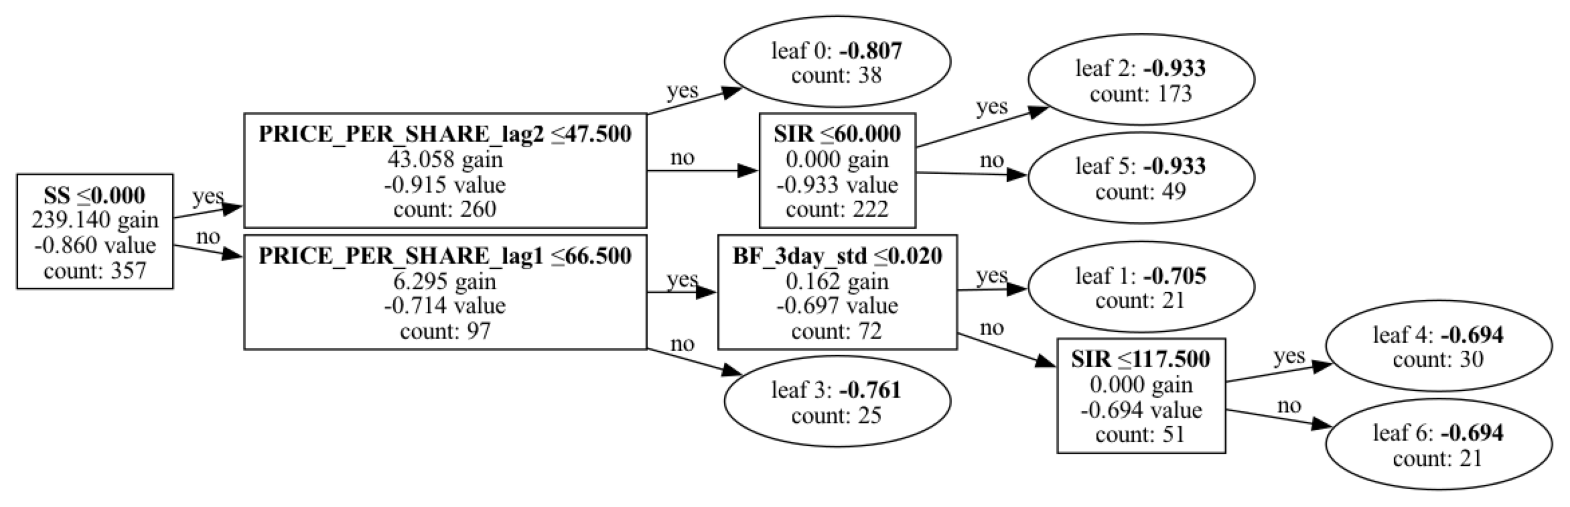

In [10]:
ax = lgb.plot_tree(clf_lgb, tree_index=0, figsize=(20, 10), show_info=['split_gain', 'internal_value', 'internal_count', 'leaf_count'])
plt.show()
        

## 6. M2: Neural Networks